## Comparison of different FDEM forward operators:
* the pyGIMLi built-in EM1dModelling using the quasi-static approximation (Ward & Hohmann, 1989)
* the Python-implementation for HEM taking dielectric displacement into account (Siemon, 2012)
* the very general empymod implementation by Werthmüller et al. (2017)

In [1]:
import numpy as np
import pygimli as pg
from pygimli.physics.em.fdem import HEMmodelling
import empymod

Both pyGIMLi-based forward operators yield the ratio of secondary to primary field, which is defined by (Ward & Hohmann, 1989)
$$ H_z = \frac{1}{4\pi\sqrt{z^2+c^2}^3} \left(\frac{3z^2}{z^2+c^2}-1 \right) $$
where c is the coil spacing and r the distance Tx-Rx. It reduces for $z=0$ to
$$ H_z = -\frac{1}{4\pi c^3} $$ 

Note that EM1dModelling was designed for ground EM and yields Hs/Hp in percent, whereas HEMModelling was designed for the HEM system that measures Hs/Hp in ppm.

We consider a frequency sounding using a classical HCP (vertical magnetic dipole transmitter and receiver at the same level) configuration.

In [2]:
coilspacing = 100.  # typical distance
freq = 2**np.arange(10) * 110.  # MaxMin/Promys system
height = 1  # both loops carried by a human
fak = 100.  # results as % of primary field

In [3]:
# Alternatively, we can use a typical airborne case like the RESOLVE bird:
if 0:
    coilspacing = 10.  # RESOLVE bird dimension
    # freq = np.array([387., 1820., 8330., 41500., 133400.])
    fak = 1e6  # typically in ppm
    height = 50.  # typical flight elevation 

Model is a three-layer model as in pyGIMLi (d1, d2, rho1, rho2, rho3) that can be formulated without (default) or with air.

In [4]:
model = [20, 20, 200, 1000, 30]
nlay = (len(model)+1) // 2

In [5]:
fop1 = pg.core.FDEM1dModelling(nlay, freq, coilspacing, height)
fas = (coilspacing**-3)/4/np.pi
fafak = fop1.freeAirSolution()[0] / fas  # bug in freeAir (pgcore<1.4)
resp1 = fop1(model) / 100 * fak * fafak  # returns %, remove fafak reveals bug for heights>>coilspacing
fop2 = HEMmodelling(nlay, height, f=freq, r=coilspacing)
resp2 = fop2(model) / 1e6 * fak  # returns ppm

We now build the operator using empymod and test it first.

In [6]:
empymod.dipole(res=[2e14, 10000],
               depth=[0],
               freqtime=freq,
               src=[0, 0, -height],
               rec=[coilspacing, 0, -height],
               ab=66, squeeze=True, verb=1, xdirect=True,
               htarg={'pts_per_dec': 0, 'dlf': 'key_51_2012'}
              )

EMArray([-1.94485429e-08+9.16241081e-05j, -1.92655848e-08+4.58124410e-05j,
         -1.90073618e-08+2.29067582e-05j, -1.86433247e-08+1.14541207e-05j,
         -1.81311873e-08+5.72807293e-06j, -1.74467671e-08+2.86557576e-06j,
         -1.72126872e-08+1.43475872e-06j, -1.45774273e-08+7.19129356e-07j,
         -1.35872905e-08+3.63162731e-07j, -1.07618539e-08+1.83320896e-07j])

In [7]:
class HCPModellingEMP(pg.frameworks.Modelling):
    """Modelling a HCP coil-coil system by empymod."""

    def __init__(self, freq, coilspacing, height=0):
        """Initialize by saving parameters."""
        super().__init__()
        self.coilspacing = coilspacing
        self.freq = freq
        self.height = height
        self.freeAir = (coilspacing**-3)/4/np.pi

    def response(self, model):
        """Forward response for layered block model."""
        nlay = (len(model)+1) // 2
        thk = model[:nlay-1]
        res = model[nlay-1:]
        assert len(res), len(thk)+1
        inp = dict(res=np.concatenate(([2e14], res)),
                   depth=np.concatenate(([0.1], np.cumsum(thk))),
                   freqtime=self.freq,
                   src=[0, 0, -self.height],
                   rec=[self.coilspacing, 0, -self.height],
                   ab=66, squeeze=True, verb=1, xdirect=True,
                   htarg={'pts_per_dec': 0, 'dlf': 'key_51_2012'}
                  )
        # print(inp)
        iwu = -1j * 2 * np.pi * self.freq * pg.physics.constants.mu0
        out = empymod.dipole(**inp) * iwu / self.freeAir - 1
        # print(out)
        return np.concatenate([out.real, out.imag])
    
fop3 = HCPModellingEMP(freq, coilspacing, height=height)
re = fop3.response([10000])  # should be mainly real-valued primary field

In [8]:
resp3 = fop3.response(model) * fak

In [9]:
print(np.column_stack([resp1, resp2, resp3]))

[[  1.35059282   1.35059217   1.35037274]
 [  2.9758696    2.9758678    2.97526396]
 [  6.04466399   6.04466034   6.04313677]
 [ 11.02951309  11.02951207  11.0260789 ]
 [ 17.52649276  17.52653122  17.5199408 ]
 [ 23.48743815  23.48768807  23.48392347]
 [ 25.89169193  25.8928015   25.90263429]
 [ 22.82343409  22.87410122  22.78429158]
 [ 11.81507458  12.01680593  12.11733279]
 [-19.28815676 -18.517901   -19.45526211]
 [  3.34701391   3.3470143    3.34712782]
 [  5.30556824   5.30556994   5.30601753]
 [  7.55062615   7.55063291   7.55219215]
 [  9.06801873   9.06804233   9.07290279]
 [  8.00580662   8.00587507   8.0194899 ]
 [  2.49928444   2.49943436   2.53491717]
 [ -7.87424394  -7.87407949  -7.73975841]
 [-22.68391501 -22.68333825 -22.58353694]
 [-43.89684416 -43.91174668 -43.48290546]
 [-70.85781938 -71.02648145 -70.57548875]]


In [10]:
def showSounding(f, resp, ax=None, **kwargs):
    """Show FDEM sounding."""
    if ax is None:
        fig, ax = pg.plt.subplots(ncols=2, sharey=True)

    ip, op = np.split(resp, 2)
    ax[0].semilogy(ip, f, **kwargs)
    ax[1].semilogy(op, f, **kwargs)
    ax[0].set_ylim(min(f), max(f))
    ax[0].grid(True)
    ax[1].grid(True)
    return ax

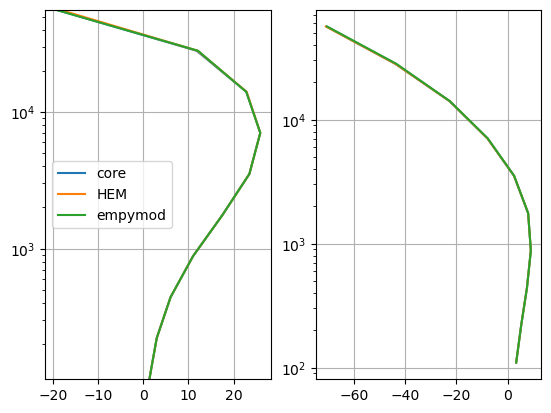

In [11]:
fig, ax = pg.plt.subplots(ncols=2)
showSounding(freq, resp1, ax=ax, label="core")
showSounding(freq, resp2, ax=ax, label="HEM")
showSounding(freq, resp3, ax=ax, label="empymod");
ax[0].legend();

### References
* Ward, S. H., and G. W. Hohmann, 1987, Electromagnetic theory for geophysical applications, in M. N. Nabighian, ed., Electromagnetic methods in applied geophysics, 1: Theory, SEG, 130–310. 
* Siemon, B. (2012): Accurate 1D forward and inverse modeling of high-frequency helicopter-borne electromagnetic data, Geophysics 77(4), WB71-87.
* Werthmüller, D. (2017): An open-source full 3D electromagnetic modeler for 1D VTI media in Python: empymod, Geophysics 82(6), WB9-19.